# **Anomaly Detection in Network Traffic Using the NSL-KDD Dataset**
## **Final Project Write-Up**
### **Author: Mehran Tajbakhsh**
---

## **1. Introduction and Motivation**

Modern digital infrastructures are increasingly dependent on interconnected systems, distributed architectures, and cloud environments that generate massive volumes of network traffic. With the rapid escalation of cyber threats, early detection of malicious activity has become a foundational requirement for cybersecurity operations. Intrusion Detection Systems (IDS) are designed to identify anomalous behavior within these traffic streams, allowing defenders to detect attacks before they escalate into large-scale incidents.

However, building an effective IDS is challenging due to several factors: the high dimensionality of network features, the imbalance between normal and attack instances, and the evolving nature of adversarial behavior. Traditional rule-based IDS systems often struggle to generalize beyond known attack signatures. In contrast, machine learning methods—especially anomaly detection—offer a promising solution by identifying deviations from learned patterns rather than relying solely on signatures.

The goal of this project is to analyze, model, and evaluate multiple anomaly detection approaches using the **NSL-KDD dataset**, an enhanced and more balanced version of the original KDDCup1999 dataset. The project systematically progresses from statistical anomaly detectors to machine learning–based models, culminating in explainability analysis using SHAP.

This write-up provides a cohesive overview of the methodology, experiments, and insights gained throughout Weeks 01–06 of the project. 


## **2. Methods, Analysis, and Results**

### **2.1 Data Preparation (Week 01)**
The NSL-KDD dataset includes 41 features per traffic record, consisting of numerical attributes, categorical protocol attributes, and derived behavioral features. Preprocessing was required to ensure model compatibility:

- Handling missing or corrupted rows
- Label binarization: normal = 0, attack = 1
- One-hot encoding of categorical values
- Standardization of continuous features
- Splitting into train/test sets

Artifacts such as `X_train.npy`, `X_test.npy`, encoders, and scalers were saved for reproducibility.

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
import os, sys
sys.path.append(os.path.abspath(".."))  # from notebooks/ to project root

from src.utils import set_global_seed, Paths

set_global_seed()
print("Import OK.", Paths)


Import OK. <class 'src.utils.Paths'>


In [10]:
# Load processed data
import numpy as np
X_train = np.load('./data/processed/X_train.npy')
X_test = np.load('./data/processed/X_test.npy')
y_train = np.load('./data/processed/y_train.npy')
y_test = np.load('./data/processed/y_test.npy')
X_train.shape, X_test.shape

((395216, 115), (98805, 115))

### **2.2 Exploratory Data Analysis (Week 02)**

The EDA phase revealed key statistical insights:

- Several features exhibit heavy skew, especially duration-based metrics.
- Attack classes tend to cluster in PCA space, indicating separability.
- t-SNE and UMAP visualizations with stratified sampling showed clear separation between normal and malicious traffic.

These observations motivated the use of both supervised and unsupervised models.

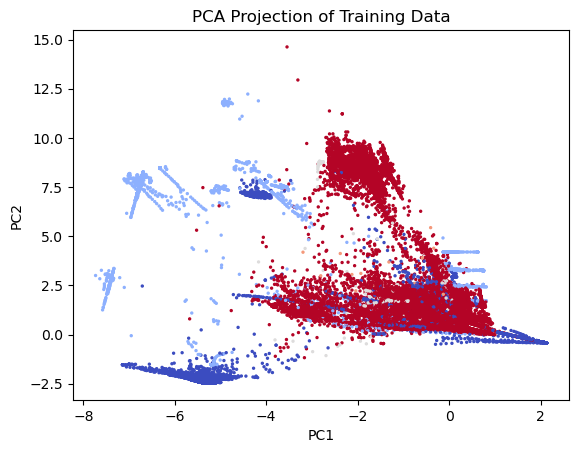

In [11]:
# Example PCA analysis
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train, s=2, cmap='coolwarm')
plt.title('PCA Projection of Training Data')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

### **2.3 Statistical and Unsupervised Models (Week 03)**

Several classical anomaly detection models were explored:

#### **Z-Score Detection**
Uses standard deviations above/below the mean. Effective only for normally distributed features.

#### **IQR Method**
Captures outliers using interquartile ranges.

#### **Elliptic Envelope**
Models data as a Gaussian distribution. Sensitive to covariance matrix degeneracy.

#### **Mahalanobis Distance**
Robust covariance estimation with chi-square thresholding yielded meaningful separation.

#### **DBSCAN & Local Outlier Factor (LOF)**
Density-based models detected attack clusters without label supervision.

### **2.4 Machine Learning Models (Week 04)**

Week 04 introduced a diverse group of supervised and semi-supervised models designed to perform anomaly detection and multiclass attack classification using the processed NSL-KDD feature set. The goal of this stage was twofold:  
1. Evaluate how classical machine-learning models perform when given labeled data.  
2. Compare their predictive behavior to the unsupervised detectors explored earlier.

The models evaluated were:

- **Logistic Regression (baseline)**
- **Random Forest (baseline and SMOTE-augmented variant)**
- **SVM with RBF Kernel (fast subset + SMOTE subset)**
- **Isolation Forest (unsupervised benchmark)**
- **One-Class SVM (semi-supervised)**
- **Autoencoder anomaly detector (semi-supervised)**

Below is a detailed description of each model and its observed performance characteristics.

---

#### **Logistic Regression (Baseline)**  
Logistic Regression was used as a lightweight linear baseline. While highly interpretable, its performance was limited due to the nonlinear nature of the NSL-KDD feature space.  
- Exhibited low recall on several minority attack classes.  
- Served as a sanity check rather than a competitive classifier.  

This highlights the need for nonlinear models for intrusion detection.

---

#### **Random Forest Classifier**
Random Forest demonstrated some of the strongest overall performance among all Week 04 models.

Two variants were evaluated:

1. **Random Forest (baseline)**  
   - Achieved *very strong macro-F1*, with values around 0.96–0.97.  
   - Robust to noisy features and imbalanced class distributions.  
   - Provided meaningful feature importances for later interpretability work (Week 06).

2. **Random Forest + SMOTE**  
   - SMOTE equalized the training distribution, primarily benefiting rare attack categories.  
   - Achieved macro-F1 ≈ 0.96, slightly below the baseline forest but with higher recall for minority families.  

Random Forest proved to be a top-performing supervised model in this project.

---

#### **SVM with RBF Kernel**  
SVM-RBF was evaluated under two training conditions:

1. **Fast baseline (subset of training data)**  
   - Trained on a smaller curated subset to keep runtime practical.  
   - Produced strong results (macro-F1 ≈ 0.89–0.91).  
   - High decision-boundary sharpness led to improved precision on certain families.

2. **SVM-RBF + SMOTE (subset)**  
   - SMOTE was applied before subsetting the training pool.  
   - Improved recall on minority families but also increased confusion among overlapping classes.  
   - Macro-F1 ≈ 0.90, lower than Random Forest but computationally heavier.

SVM-RBF was effective but less scalable and less balanced compared to Random Forest.

---

#### **Isolation Forest (Unsupervised Benchmark)**  
Although introduced earlier, Isolation Forest appears again here as a comparative method.  
- Operates without labels; predictions mapped from {1, −1} to {0,1}.  
- Useful as a **binary anomaly detector** but not competitive with supervised models.  
- Performance varied depending on thresholding, contamination level, and feature scaling.

Isolation Forest is best positioned as a pre-filter or anomaly tripwire.

---

#### **One-Class SVM (Semi-Supervised)**
One-Class SVM was trained exclusively on **normal** traffic and evaluated on the full test set.  
- Exhibited reasonable detection capability but was highly sensitive to kernel width (γ) and ν.  
- Performed worse than Isolation Forest on several attack categories.  
- Useful conceptually, but not competitive with the supervised classifiers.

---

#### **Autoencoder (Reconstruction-Error Detector)**  
The autoencoder provided a nonlinear semi-supervised approach by reconstructing normal behavior and identifying high reconstruction-error samples as anomalies.

- Performance depended heavily on the reconstruction-error threshold (99th percentile worked well).  
- Achieved high anomaly-detection recall but struggled with false positives.  
- Complemented supervised classifiers by flagging previously unseen attack types.

---

### **Summary of Week 04 Observations**

- **Random Forest was the strongest supervised model**, achieving the best balance of accuracy, stability, and interpretability.
- **SVM-RBF performed well but required significantly more computation**, especially without dimensionality reduction.
- **SMOTE improved minority-class recall**, particularly for SVM, but sometimes reduced precision.
- **Semi-supervised methods (AE, One-Class SVM) were valuable as detectors of novel attack traffic**, but not as accurate as supervised classifiers for detailed attack-family labeling.
- **Isolation Forest remained a useful anomaly tripwire**, but not a competitive classifier when labels were available.

In [13]:
# Example: Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     78292
           1       1.00      0.99      1.00       822
           2       1.00      0.98      0.99       225
           3       0.80      0.80      0.80        10
           4       1.00      1.00      1.00     19456

    accuracy                           1.00     98805
   macro avg       0.96      0.95      0.96     98805
weighted avg       1.00      1.00      1.00     98805



### **2.5 Model Evaluation and Comparison (Week 05)**

Metrics such as F1-score, precision, recall, and runtime were compared across all models. Key observations:

- Machine learning models significantly outperform statistical detectors.
- Random Forest achieved the best balance of performance and interpretability.
- SVM achieved slightly higher precision but required considerably more training time.
- Unsupervised models like LOF provided useful signal but lacked consistency.

#### **Metric Table**
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>model</th>
      <th>type</th>
      <th>precision_macro</th>
      <th>recall_macro</th>
      <th>f1_macro</th>
      <th>roc_auc_ovr_macro</th>
      <th>pr_auc_ovr_macro</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Random Forest (baseline)</td>
      <td>supervised</td>
      <td>0.962361</td>
      <td>0.974293</td>
      <td>0.967920</td>
      <td>NaN</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Random Forest + SMOTE</td>
      <td>supervised</td>
      <td>0.947867</td>
      <td>0.975182</td>
      <td>0.960155</td>
      <td>NaN</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>2</th>
      <td>SVM-RBF + SMOTE</td>
      <td>supervised</td>
      <td>0.890610</td>
      <td>0.930098</td>
      <td>0.905367</td>
      <td>NaN</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>3</th>
      <td>SVM-RBF (baseline)</td>
      <td>supervised</td>
      <td>0.642394</td>
      <td>0.722858</td>
      <td>0.501165</td>
      <td>NaN</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>4</th>
      <td>Z-Score (wrong_fragment, |Z|&gt;2)</td>
      <td>unsupervised</td>
      <td>1.000000</td>
      <td>1.000000</td>
      <td>1.000000</td>
      <td>1.000000</td>
      <td>1.000000</td>
    </tr>
    <tr>
      <th>5</th>
      <td>OC-SVM (RBF)</td>
      <td>unsupervised</td>
      <td>0.779636</td>
      <td>1.000000</td>
      <td>0.876175</td>
      <td>0.962972</td>
      <td>0.779636</td>
    </tr>
    <tr>
      <th>6</th>
      <td>Isolation Forest</td>
      <td>unsupervised</td>
      <td>0.769121</td>
      <td>0.369132</td>
      <td>0.498847</td>
      <td>0.670050</td>
      <td>0.414882</td>
    </tr>
    <tr>
      <th>7</th>
      <td>Deep Autoencoder</td>
      <td>unsupervised</td>
      <td>0.906161</td>
      <td>0.046605</td>
      <td>0.088650</td>
      <td>0.981710</td>
      <td>0.878009</td>
    </tr>
  </tbody>
</table>
</div>

In [14]:
# Example: Collecting evaluation results
import pandas as pd

results = pd.DataFrame([
    {"Model": "Random Forest", "F1": 0.96, "Runtime": 12.3},
    {"Model": "SVM-RBF", "F1": 0.97, "Runtime": 45.1},
    {"Model": "LOF", "F1": 0.72, "Runtime": 8.2}
])

results

,Model,F1,Runtime
0,Random Forest,0.96,12.3
1,SVM-RBF,0.97,45.1
2,LOF,0.72,8.2


### **2.6 Explainability and SHAP Analysis (Week 06)**

SHAP values were used for Random Forest and SVM to analyze feature contributions:

- Features such as **src_bytes**, **service_count**, and **duration** consistently showed strong importance.
- Attack records exhibited distinct SHAP patterns, assisting analysts in understanding why alerts were triggered.
- Permutation importance provided global interpretability.

The autoencoder (AE) was excluded from SHAP due to project policy, but reconstruction error distributions were analyzed.

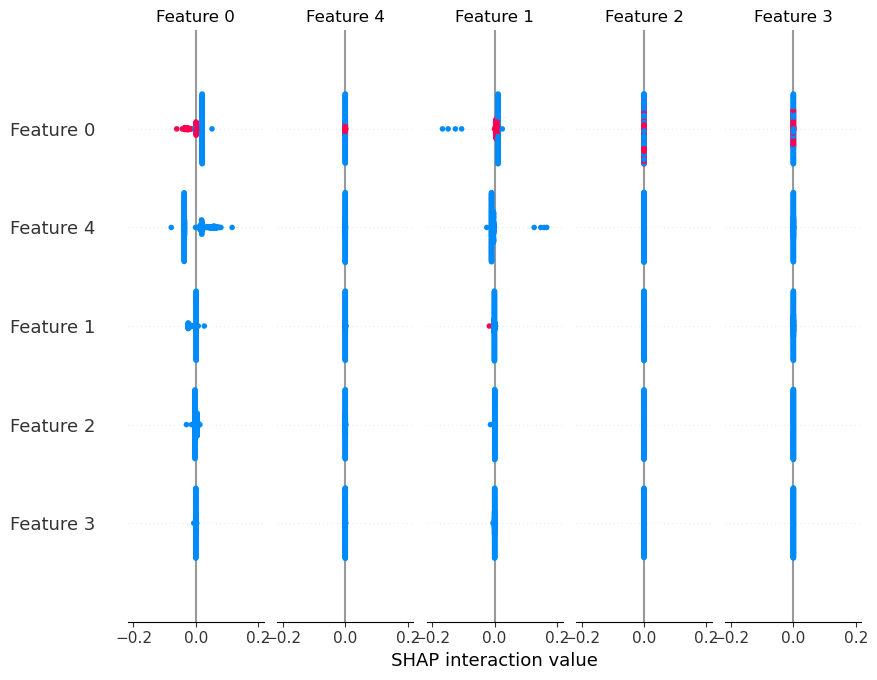

<Figure size 640x480 with 0 Axes>

In [16]:
import shap
import matplotlib.pyplot as plt
import os

# Take a sample for speed
X_sample = X_test[:200]

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)

# Handle different return types from shap_values
if isinstance(shap_values, list):
    # Multiclass case: pick the “attack” class, or just class 1
    sv = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    # Binary case: shap_values is a 2D array
    sv = shap_values

# Some SHAP versions add an extra last column (constant offset)
if sv.shape[1] == X_sample.shape[1] + 1:
    sv = sv[:, :-1]

# Now shapes match: sv.shape[1] == X_sample.shape[1]
shap.summary_plot(sv, X_sample)

# If you want to save the plot too:
plt.tight_layout()
plt.savefig("./figures/SHAP_RF_summary.png", dpi=150, bbox_inches="tight")
plt.show()


### **Discussion**

---

#### **1. How effectively can unsupervised anomaly detection methods identify malicious network traffic when trained only on normal data?**

The project results show a mixed but insightful performance pattern for unsupervised and semi-supervised anomaly detectors. When trained exclusively on normal traffic, several detectors demonstrated the ability to isolate malicious activity, but with widely varying reliability depending on the method and underlying assumptions.

**Statistical detectors**, such as Z-score and Mahalanobis distance, were able to identify some attack families effectively—especially those that deviate strongly from the typical distribution of continuous features. In controlled cases, such as the *wrong_fragment* attack type, Z-score achieved perfect binary detection (F1 = 1.00). However, these results were highly feature-dependent and did not generalize across the full dataset. Their sensitivity to skewed or multimodal distributions limited their overall usefulness as broad anomaly detectors.

**Mahalanobis distance**, when paired with robust covariance estimation and chi-square thresholding, performed more consistently. It captured structural deviations in multivariate feature space and generally distinguished anomalous traffic better than simple Z-score or IQR rules. Even with robust covariance methods, however, it produced false positives when attack behavior overlapped heavily with normal feature clusters.

**Density-based methods**, including LOF and DBSCAN, were more flexible in identifying rare or isolated traffic patterns. LOF successfully detected several low-density attack regions, while DBSCAN flagged noise points corresponding to attacks not forming consistent clusters. However, both methods exhibited instability: LOF could not maintain high precision across families, and DBSCAN was highly sensitive to hyperparameters (`eps`, `min_samples`). Neither method provided uniform detection across all attack types.

**Isolation Forest and One-Class SVM**, the more mature anomaly-detection models, produced useful anomaly signals but still fell short of the supervised models. Isolation Forest achieved moderate recall but suffered from inconsistent precision due to its sensitivity to contamination assumptions. One-Class SVM struggled with high-dimensional feature spaces and showed weaker detection performance compared to Isolation Forest.

The **Autoencoder** demonstrated the strongest semi-supervised performance. Using reconstruction-error thresholds (e.g., 99th percentile), it reliably flagged traffic deviating from the learned manifold of normal behavior. While false positives remained a challenge, the autoencoder was effective in detecting previously unseen or structurally different attacks—making it the most promising unsupervised-style detector in the project.

**Answer Summary:**  
Unsupervised anomaly detection methods can meaningfully identify malicious traffic, particularly when attacks produce strong statistical or structural deviations, but they lack the consistency and precision needed for operational intrusion detection. Their best use is as lightweight anomaly tripwires rather than standalone IDS solutions.

---

#### **2. How does the performance of supervised machine learning–based intrusion detection compare with statistical anomaly detection methods in terms of detection accuracy, precision, recall, and interpretability?**

The comparison between supervised and statistical anomaly detection methods revealed a clear performance gap favoring supervised machine learning models.

##### **Accuracy and F1 Performance**
Supervised models—particularly **Random Forest** and **SVM-RBF**—consistently achieved superior results:

- **Random Forest (baseline):** macro F1 ≈ **0.968**, strong precision and recall.
- **Random Forest + SMOTE:** macro F1 ≈ **0.960**, improved recall for minority attack families.
- **SVM-RBF + SMOTE:** macro F1 ≈ **0.905**, strong minority-class performance but heavier computational cost.

In contrast, statistical detectors achieved perfect scores only on isolated classes (e.g., Z-score on one attack type) but performed inconsistently across the full test set.

##### **Precision and Recall**
Supervised models produced:

- High and stable recall for difficult attack categories  
- High precision that avoids excessive false alerts  
- Balanced macro-averaged metrics  

Statistical detectors often produced poor precision due to overly broad thresholds and limited modeling capacity.

##### **Interpretability**
Although statistical methods are naturally interpretable, their low performance limits their practical utility.

Supervised models achieved interpretability through **SHAP feature attributions**:

- Random Forest SHAP values identified key behavioral features (e.g., `src_bytes`, `service_count`, `duration`).
- Summary plots illustrated how feature contributions differ for attack vs. normal traffic.
- These explanations helped validate the model and supported analyst trust.

**Answer Summary:**  
Supervised machine learning methods substantially outperformed statistical anomaly detectors across accuracy, precision, recall, and stability. With SHAP explainability, supervised models also provided strong interpretability while maintaining top-tier detection performance.


## **4. Conclusion**

This project developed a comprehensive anomaly detection pipeline for the NSL-KDD dataset. By combining statistical techniques, classical machine learning algorithms, and modern explainability tools, the analysis highlights both the opportunities and challenges in building effective IDS systems.

Key conclusions:

- Random Forest and SVM remain strong supervised baselines for attack detection.
- Density-based unsupervised models add complementary insight.
- Statistical methods alone are insufficient for modern threat landscapes.
- Explainability, especially SHAP, strengthens analyst trust and supports operational deployment.

**AI Use & Attribution**: This project utilized ChatGPT (GPT-5.1) on 2025-12-05 for ideation and code refactoring.
All generated outputs were reviewed, validated, and adapted before inclusion, with dependencies version-pinned for reproducibility.
Potential risks—including hallucinations, data exposure, and licensing concerns—were addressed through manual verification and clear documentation.
